# CB Model

The following tries to reproduce Fig 10 from [Hawkes, Jalali, Colquhoun (1992)](http://dx.doi.org/10.1098/rstb.1992.0116). First we create the $Q$-matrix for this particular model from [Hawkes, Jalali, Colquhoun (1992)](http://dx.doi.org/10.1098/rstb.1992.0116). First we create the $Q$-matrix for this particular model.

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from dcprogs.likelihood import QMatrix

tau = 0.2
qmatrix = QMatrix([ [-2,    1,   1,    0], 
                    [ 1, -101,   0,  100], 
                    [50,    0, -50,    0],
                    [ 0,  5.6,   0, -5.6]], 1)

We then create a function to plot each exponential component in the asymptotic expression. An explanation on how to get to these plots can be found in the **CH82** notebook.

In [4]:
from dcprogs.likelihood._methods import exponential_pdfs

def plot_exponentials(qmatrix, tau, x0=None, x=None, ax=None, nmax=2, shut=False):
    from dcprogs.likelihood import missed_events_pdf
    from dcprogs.likelihood._methods import exponential_pdfs

    if x is None: x = np.arange(0, 5*tau, tau/10)
    if x0 is None: x0 = x
    pdf = missed_events_pdf(qmatrix, tau, nmax=nmax, shut=shut)
    graphb = [x0, pdf(x0+tau), '-k']
    functions = exponential_pdfs(qmatrix, tau, shut=shut)
    plots = ['.r', '.b', '.g'] 
    together = None
    for f, p in zip(functions[::-1], plots):
        if together is None: together = f(x+tau)
        else: together = together + f(x+tau)
        graphb.extend([x, together, p])

    if ax is None: plot(*graphb)
    else: ax.plot(*graphb)

For practical reasons, we plot the excess shut-time probability densities in the graph below. In all other particulars, it should reproduce Fig. 10 from [Hawkes, Jalali, Colquhoun (1992)](http://dx.doi.org/10.1098/rstb.1992.0116)

<IPython.core.display.Javascript object>


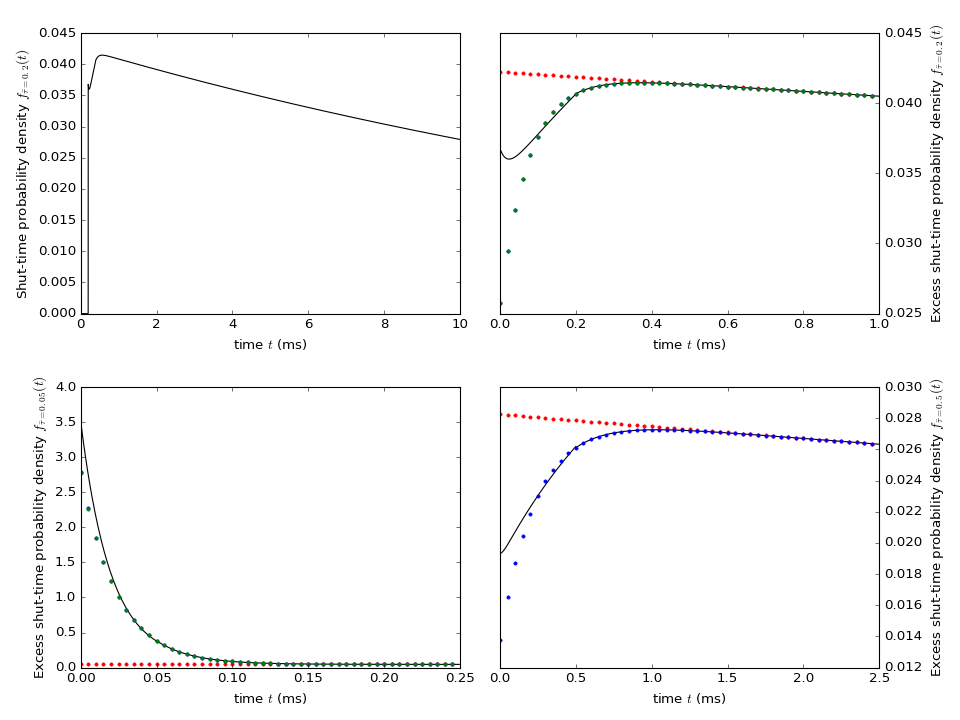

In [5]:
from dcprogs.likelihood import missed_events_pdf

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(2, 2, 1)
x = np.arange(0, 10, tau/100)
pdf = missed_events_pdf(qmatrix, 0.2, nmax=2, shut=True)
ax.plot(x, pdf(x), '-k')
ax.set_xlabel('time $t$ (ms)')
ax.set_ylabel('Shut-time probability density $f_{\\bar{\\tau}=0.2}(t)$')


ax = fig.add_subplot(2, 2, 2)
ax.set_xlabel('time $t$ (ms)')
tau = 0.2
x, x0 = np.arange(0, 5*tau, tau/10.0), np.arange(0, 5*tau, tau/100) 
plot_exponentials(qmatrix, tau, shut=True, ax=ax, x=x, x0=x0)
ax.set_ylabel('Excess shut-time probability density $f_{{\\bar{{\\tau}}={tau}}}(t)$'.format(tau=tau))
ax.set_xlabel('time $t$ (ms)')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax = fig.add_subplot(2, 2, 3)
tau = 0.05
x, x0 = np.arange(0, 5*tau, tau/10.0), np.arange(0, 5*tau, tau/100) 
plot_exponentials(qmatrix, tau, shut=True, ax=ax, x=x, x0=x0)
ax.set_ylabel('Excess shut-time probability density $f_{{\\bar{{\\tau}}={tau}}}(t)$'.format(tau=tau))
ax.set_xlabel('time $t$ (ms)')

ax = fig.add_subplot(2, 2, 4)
tau = 0.5
x, x0 = np.arange(0, 5*tau, tau/10.0), np.arange(0, 5*tau, tau/100) 
plot_exponentials(qmatrix, tau, shut=True, ax=ax, x=x, x0=x0)
ax.set_ylabel('Excess shut-time probability density $f_{{\\bar{{\\tau}}={tau}}}(t)$'.format(tau=tau))
ax.set_xlabel('time $t$ (ms)')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

#fig.subplots_adjust(wspace=0.1)
fig.tight_layout()

In [6]:
from dcprogs.likelihood import DeterminantEq, find_root_intervals, find_lower_bound_for_roots
from numpy.linalg import eig
tau = 0.5
determinant = DeterminantEq(qmatrix, tau).transpose()
# print find_lower_bound_for_roots(determinant)
x = np.arange(-100, -3, 0.1)
#plot(x, determinant(x))

matrix = qmatrix.transpose()
qaffa = np.array(np.dot(matrix.af, matrix.fa), dtype='f16')
aa = np.array(matrix.aa, dtype='f16')

def anaH(s):
    from numpy.linalg import det 
    from numpy import identity, exp
    arg0 = 1e0/np.array(-2-s, dtype='f16')
    arg1 = np.array(-(2+s) * tau, dtype='f16')
    return qaffa * (exp(arg1) - np.array(1e0, dtype='f16')) * arg0 + aa

def anadet(s):
    from numpy.linalg import det 
    from numpy import identity, exp
    s = np.array(s, dtype='f16')
    matrix = s*identity(qaffa.shape[0], dtype='f16') - anaH(s)
    return matrix[0,0] * matrix[1, 1] * matrix[2, 2]          \
           + matrix[1,0] * matrix[2, 1] * matrix[0, 2]        \
           + matrix[0,1] * matrix[1, 2] * matrix[2, 0]        \
           - matrix[2,0] * matrix[1, 1] * matrix[0, 2]        \
           - matrix[1,0] * matrix[0, 1] * matrix[2, 2]        \
           - matrix[2,1] * matrix[1, 2] * matrix[0, 0]   

x = np.arange(-100, -3, 1e-2)
print(find_lower_bound_for_roots(determinant))
print(eig(np.array(anaH(-160 ), dtype='float64'))[0])
print(anadet(-104))
#plot(x, [anadet(u) for u in x])

-127.57622909968111
[  0.00000000e+00   6.57926167e+33  -5.60000000e+00]
0.0
